In [1]:
pip install tensorflow opencv-python numpy pandas kaggle

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import cv2
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Define paths to your dataset
train_dir = '/kaggle/input/fer2013/test'  # Adjust path to your train folder
test_dir = '/kaggle/input/fer2013/train'    # Adjust path to your test folder (optional)

# Emotion labels (based on folder names)
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
num_classes = len(emotion_labels)



In [3]:
# Function to load and preprocess images from a directory
def load_images_from_folder(folder, img_size=(48, 48)):
    images = []
    labels = []
    
    for label_idx, emotion in enumerate(emotion_labels):
        emotion_folder = os.path.join(folder, emotion)
        if not os.path.exists(emotion_folder):
            print(f"Folder {emotion_folder} not found, skipping...")
            continue
        
        for img_name in os.listdir(emotion_folder):
            img_path = os.path.join(emotion_folder, img_name)
            # Read image in grayscale
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue  # Skip if image can't be loaded
            
            # Resize to 48x48
            img = cv2.resize(img, img_size)
            images.append(img)
            labels.append(label_idx)  # Label as index (0 for angry, 1 for disgust, etc.)
    
    return np.array(images), np.array(labels)

# Load training data
print("Loading training data...")
X, y = load_images_from_folder(train_dir)



Loading training data...


In [4]:
# Preprocess the data
X = X.astype('float32') / 255.0  # Normalize to [0, 1]
X = np.expand_dims(X, -1)  # Add channel dimension: (samples, 48, 48, 1)
y = to_categorical(y, num_classes=num_classes)  # One-hot encode labels

# If you have a test folder, load it; otherwise, split the train data
if os.path.exists(test_dir):
    print("Loading test data...")
    X_test, y_test = load_images_from_folder(test_dir)
    X_test = X_test.astype('float32') / 255.0
    X_test = np.expand_dims(X_test, -1)
    y_test = to_categorical(y_test, num_classes=num_classes)
else:
    print("No test folder found, splitting train data (80-20)...")
    X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Loading test data...


In [5]:
# Build the CNN model (same as before)
model = Sequential()

# Conv Block 1
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Conv Block 2
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Conv Block 3
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Dense Layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  # 7 emotions

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,872,583 (22.40 MB)

 Trainable params: 5,869,767 (22.39 MB)

 Non-trainable params: 2,816 (11.00 KB)

Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 24s 113ms/step - accuracy: 0.2168 - loss: 2.6388 - val_accuracy: 0.2513 - val_loss: 2.7131
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.3354 - loss: 1.9595 - val_accuracy: 0.2532 - val_loss: 1.9061
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.3864 - loss: 1.7260 - val_accuracy: 0.1829 - val_loss: 1.9204
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.4477 - loss: 1.4908 - val_accuracy: 0.3091 - val_loss: 1.6591
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.5107 - loss: 1.3463 - val_accuracy: 0.4363 - val_loss: 1.5010
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.5260 - loss: 1.2820 - val_accuracy: 0.4922 - val_loss: 1.3515
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.5574 - loss: 1.1611 - val_accuracy: 0.4857 - val_loss: 1.3942
Epoch 8/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.6059 - loss: 1.0625 - val_ac

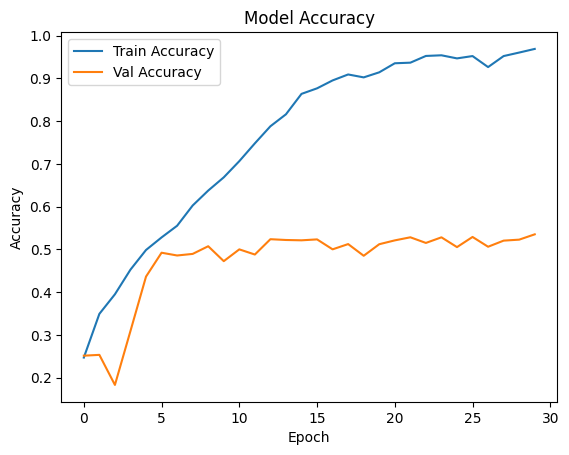

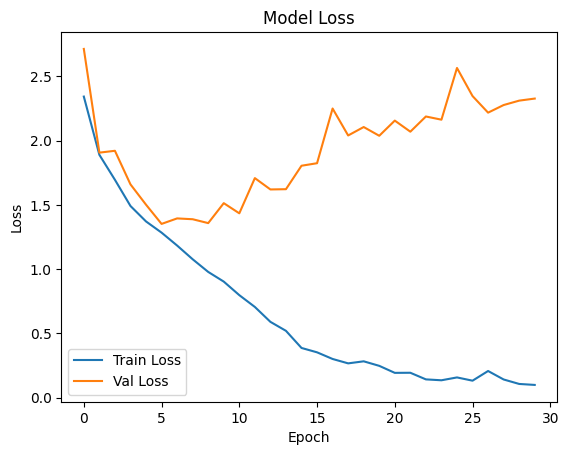

In [6]:
# Train the model
history = model.fit(X, y, 
                    batch_size=64, 
                    epochs=30,  # Adjust if needed
                    validation_data=(X_test, y_test))

# Save the model
model.save('emotion_model.h5')
print("Model saved as 'emotion_model.h5'. Ready to vibe with some music!")

# Plot accuracy/loss
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Loading training data...
Loading test data...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       2,359,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 256)                 │           1,0

 Total params: 2,919,111 (11.14 MB)

 Trainable params: 2,917,319 (11.13 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


449/449 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.1785 - loss: 9.7398 - val_accuracy: 0.0254 - val_loss: 10.3657 - learning_rate: 0.0010
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.2485 - loss: 3.6381 - val_accuracy: 0.3423 - val_loss: 2.5827 - learning_rate: 0.0010
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.3312 - loss: 2.5515 - val_accuracy: 0.1741 - val_loss: 2.9021 - learning_rate: 0.0010
Epoch 4/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.3604 - loss: 2.5319 - val_accuracy: 0.4079 - val_loss: 2.5182 - learning_rate: 0.0010
Epoch 5/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.3700 - loss: 2.5761 - val_accuracy: 0.4264 - val_loss: 2.4372 - learning_rate: 0.0010
Epoch 6/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.3713 - loss: 2.5890 - val_accuracy: 0.1927 - val_loss: 3.0542 - learning_rate: 0.0010
Epoch 7/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.3774 - loss: 2.614

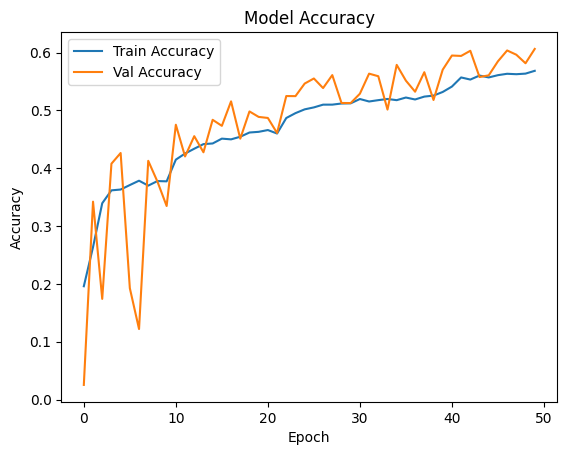

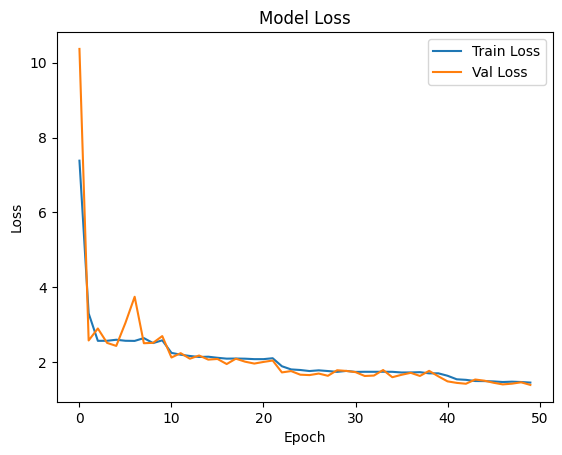

In [8]:
import numpy as np
import cv2
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# Define paths to your dataset
train_dir = '/kaggle/input/fer2013/train'  # Adjust path to your train folder
test_dir = '/kaggle/input/fer2013/test'    # Adjust path to your test folder (optional)

# Emotion labels
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
num_classes = len(emotion_labels)

# Function to load and preprocess images from a directory
def load_images_from_folder(folder, img_size=(48, 48)):
    images = []
    labels = []
    
    for label_idx, emotion in enumerate(emotion_labels):
        emotion_folder = os.path.join(folder, emotion)
        if not os.path.exists(emotion_folder):
            print(f"Folder {emotion_folder} not found, skipping...")
            continue
        
        for img_name in os.listdir(emotion_folder):
            img_path = os.path.join(emotion_folder, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            
            img = cv2.resize(img, img_size)
            images.append(img)
            labels.append(label_idx)
    
    return np.array(images), np.array(labels)

# Load training data
print("Loading training data...")
X, y = load_images_from_folder(train_dir)

# Preprocess the data
X = X.astype('float32') / 255.0
X = np.expand_dims(X, -1)
y = to_categorical(y, num_classes=num_classes)

# Load test data or split train data
if os.path.exists(test_dir):
    print("Loading test data...")
    X_test, y_test = load_images_from_folder(test_dir)
    X_test = X_test.astype('float32') / 255.0
    X_test = np.expand_dims(X_test, -1)
    y_test = to_categorical(y_test, num_classes=num_classes)
else:
    print("No test folder found, splitting train data (80-20)...")
    X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Compute class weights to handle imbalance
y_labels = np.argmax(y, axis=1)  # Convert one-hot back to labels for class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_labels), y=y_labels)
class_weights_dict = dict(enumerate(class_weights))

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Build the improved CNN model
model = Sequential()

# Conv Block 1
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(48, 48, 1), kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))  # Increased dropout

# Conv Block 2
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

# Conv Block 3
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

# Dense Layers
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))  # Reduced dense layer size
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model with augmentation and class weights
history = model.fit(
    datagen.flow(X, y, batch_size=64),
    epochs=50,  # More epochs, but early stopping will kick in
    validation_data=(X_test, y_test),
    class_weight=class_weights_dict,
    callbacks=[early_stopping, lr_scheduler]
)

# Save the improved model
model.save('emotion_model_improved.h5')
print("Improved model saved as 'emotion_model_improved.h5'. Let’s see those gains!")

# Plot accuracy/loss
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()